In [1]:
from six import StringIO
from IPython.display import Image
import pandas as pd
import numpy as np
from scipy.io import arff
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import tree
import graphviz
from sklearn.tree import export_graphviz
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pydotplus

In [2]:
data = arff.loadarff("Airlines.arff")
df = pd.DataFrame(data[0])

In [3]:
df["UniqueCarrier"] = df["UniqueCarrier"].astype(str).str.replace("[b'']","")
df["FlightNum"] = df["FlightNum"].astype(str).str.replace("[b'']","").astype(float)
df["Origin"] = df["Origin"].astype(str).str.replace("[b'']","")
df["Dest"] = df["Dest"].astype(str).str.replace("[b'']","")

In [4]:
df.dropna()
df.drop_duplicates(inplace=True)

In [5]:
df = df.astype({"DayofWeek":"int64", "CRSDepTime":"int64", "FlightNum":"int64", "ArrDelay":"int64"})

In [6]:
df.describe()

,DayofWeek,CRSDepTime,FlightNum,ArrDelay
count,85295.000000,85295.000000,85295.000000,85295.000000
mean,3.948238,1368.061750,897.183282,5.703969
std,1.983011,459.897195,476.571839,24.862070
min,1.000000,5.000000,12.000000,-72.000000
25%,2.000000,935.000000,539.000000,-7.000000
50%,4.000000,1346.000000,1000.000000,1.000000
75%,6.000000,1740.000000,1264.000000,11.000000
max,7.000000,2359.000000,4007.000000,667.000000


In [7]:
df.shape

(85295, 7)

In [8]:
df.dtypes

DayofWeek         int64
CRSDepTime        int64
UniqueCarrier    object
FlightNum         int64
Origin           object
Dest             object
ArrDelay          int64
dtype: object

## Average delay per airline

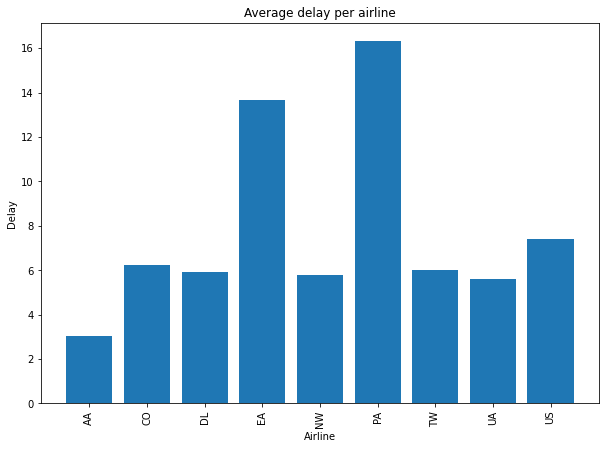

In [20]:
airline = df.groupby("UniqueCarrier")["ArrDelay"].mean()
plt.figure(figsize=(10, 7))
plt.bar(x=airline.index, height=airline.values)
plt.xlabel("Airline")
plt.xticks(rotation=90)
plt.ylabel("Delay")
plt.title("Average delay per airline")
plt.show()

## Average delay per origin airport

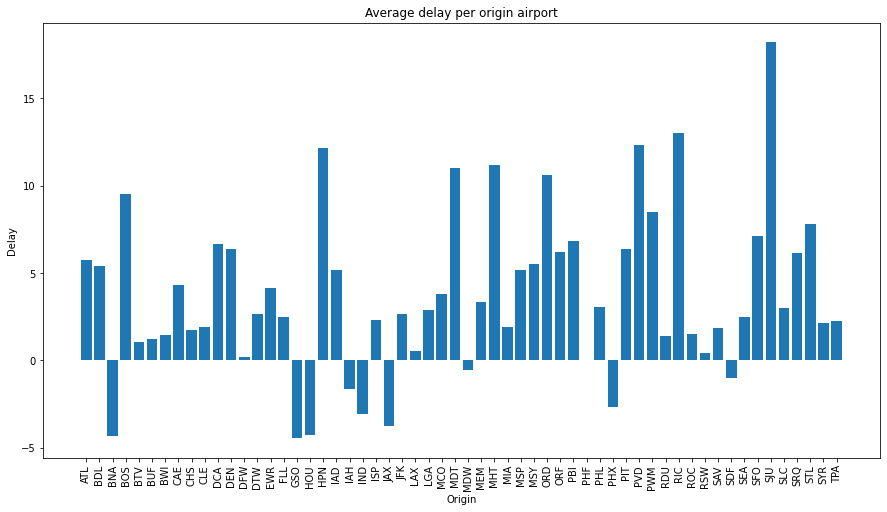

In [3]:
origin = df.groupby("Origin")["ArrDelay"].mean()
plt.figure(figsize=(15, 8))
plt.bar(x=origin.index, height=origin.values)
plt.xlabel("Origin")
plt.xticks(rotation=90)
plt.ylabel("Delay")
plt.title("Average delay per origin airport")
plt.show()

## Average delay per destination airport

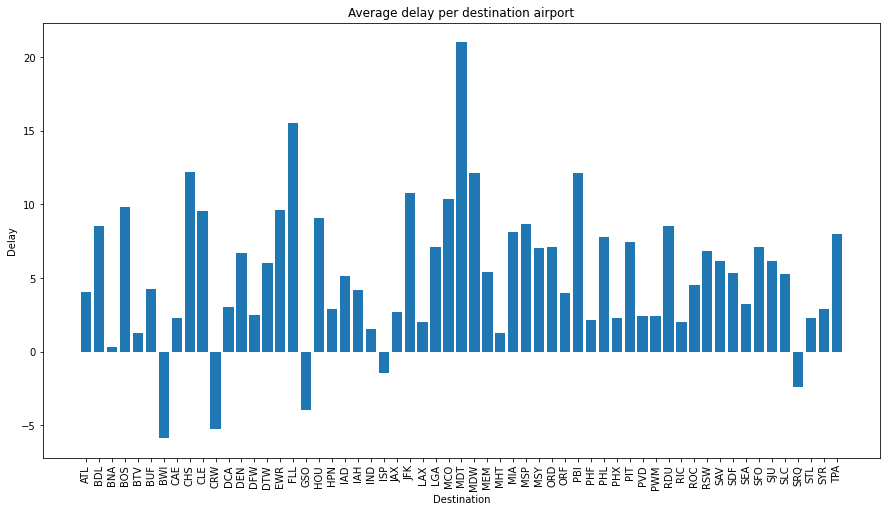

In [12]:
dest = df.groupby("Dest")["ArrDelay"].mean()
plt.figure(figsize=(15, 8))
plt.bar(x=dest.index, height=dest.values)
plt.xlabel("Destination")
plt.xticks(rotation=90)
plt.ylabel("Delay")
plt.title("Average delay per destination airport")
plt.show()

### Binning

In [13]:
bins = [-80, 0, 40, 700]
labels = [1,2,3]
df['Delay'] = pd.cut(df['ArrDelay'], bins=bins, labels=labels)
df

,DayofWeek,CRSDepTime,UniqueCarrier,FlightNum,Origin,Dest,ArrDelay,Delay
0,5,600,UA,899,ORD,IAD,-3,1
1,5,615,DL,357,IAD,ATL,5,2
2,5,615,UA,341,IAD,DEN,8,2
3,5,625,CO,581,IAD,DEN,44,3
4,5,630,UA,902,CLE,IAD,-10,1
...,...,...,...,...,...,...,...,...
100154,6,2135,UA,1576,IAD,LGA,-19,1
100157,6,2140,CO,896,LAX,IAD,-23,1
100158,6,2150,UA,1094,IAD,BDL,-14,1
100159,6,2155,US,394,PIT,IAD,9,2


<AxesSubplot:xlabel='Delay', ylabel='count'>

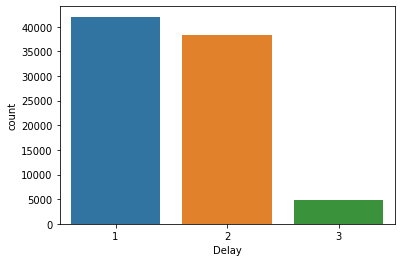

In [14]:
df['Delay'].value_counts()
sns.countplot(x=df['Delay'], label='count')

## Rules of association between delays and point of origin AND point of arrival

In [15]:
encoded_df = pd.DataFrame(df)
encoded_df.drop("ArrDelay", axis=1, inplace=True)
encoded_df["CRSDepTime"] = encoded_df["CRSDepTime"] // 100

temp = pd.get_dummies(encoded_df.DayofWeek, prefix="DayofWeek")
encoded_df = encoded_df.join(temp)
encoded_df.drop("DayofWeek", axis=1, inplace=True)

temp = pd.get_dummies(encoded_df.CRSDepTime, prefix="CRSDepTime")
encoded_df = encoded_df.join(temp)
encoded_df.drop("CRSDepTime", axis=1, inplace=True)

temp = pd.get_dummies(encoded_df.UniqueCarrier, prefix="UniqueCarrier")
encoded_df = encoded_df.join(temp)
encoded_df.drop("UniqueCarrier", axis=1, inplace=True)

temp = pd.get_dummies(encoded_df.FlightNum, prefix="FlightNum")
encoded_df = encoded_df.join(temp)
encoded_df.drop("FlightNum", axis=1, inplace=True)

temp = pd.get_dummies(encoded_df.Origin, prefix="Origin")
encoded_df = encoded_df.join(temp)
encoded_df.drop("Origin", axis=1, inplace=True)

temp = pd.get_dummies(encoded_df.Dest, prefix="Dest")
encoded_df = encoded_df.join(temp)
encoded_df.drop("Dest", axis=1, inplace=True)

temp = pd.get_dummies(encoded_df.Delay, prefix="Delay")
encoded_df = encoded_df.join(temp)
encoded_df.drop("Delay", axis=1, inplace=True)

encoded_df

,DayofWeek_1,DayofWeek_2,DayofWeek_3,DayofWeek_4,DayofWeek_5,DayofWeek_6,DayofWeek_7,CRSDepTime_0,CRSDepTime_5,CRSDepTime_6,...,Dest_SFO,Dest_SJU,Dest_SLC,Dest_SRQ,Dest_STL,Dest_SYR,Dest_TPA,Delay_1,Delay_2,Delay_3
0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100154,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
100157,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
100158,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
100159,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [16]:
# Building the model
frq_items = apriori(encoded_df, min_support = 0.01, use_colnames = True)
rules = association_rules(frq_items, metric ="confidence", min_threshold = 0.55)

rules["antecedents"] = rules["antecedents"].apply(lambda x: ', '.join(list(x))).astype("string")
rules["consequents"] = rules["consequents"].apply(lambda x: ', '.join(list(x))).astype("string")

features_or_dest = ["DayofWeek_", "UniqueCarrier_", "CRSDepTime_", "Delay_"]
features_delay = ["DayofWeek_", "UniqueCarrier_", "CRSDepTime_", "Dest_", "Origin_"]
rules = rules[rules["antecedents"].str.contains("|".join(features_or_dest)) == False]
rules = rules[rules["consequents"].str.contains("|".join(features_delay)) == False]

rules.sort_values(by=['confidence','support'],inplace=True,ascending=False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
107,Dest_PIT,Delay_2,0.016754,0.450343,0.011126,0.664101,1.474656,0.003581,1.636375
363,"Dest_PIT, Origin_IAD",Delay_2,0.016754,0.450343,0.011126,0.664101,1.474656,0.003581,1.636375
102,Origin_PIT,Delay_2,0.016589,0.450343,0.010176,0.613428,1.362134,0.002705,1.421873
373,"Origin_PIT, Dest_IAD",Delay_2,0.016589,0.450343,0.010176,0.613428,1.362134,0.002705,1.421873
73,Origin_DFW,Delay_1,0.020693,0.492866,0.012170,0.588102,1.193229,0.001971,1.231213
342,"Origin_DFW, Dest_IAD",Delay_1,0.020693,0.492866,0.012170,0.588102,1.193229,0.001971,1.231213
75,Origin_DTW,Delay_1,0.021420,0.492866,0.012240,0.571429,1.159400,0.001683,1.183313
345,"Origin_DTW, Dest_IAD",Delay_1,0.021420,0.492866,0.012240,0.571429,1.159400,0.001683,1.183313
106,Dest_LAX,Delay_1,0.026074,0.492866,0.014467,0.554856,1.125775,0.001616,1.139259
357,"Dest_LAX, Origin_IAD",Delay_1,0.026074,0.492866,0.014467,0.554856,1.125775,0.001616,1.139259


# Predict the delay given all other features

In [17]:
pred_enc_df = pd.DataFrame(encoded_df)
pred_enc_df.drop(["Delay_1", "Delay_2", "Delay_3"], axis=1, inplace=True)
pred_enc_df["Delay"] = df["Delay"]
X = pred_enc_df.iloc[:,0:-1]
Y = pred_enc_df.iloc[:,-1]

dt = DecisionTreeClassifier(criterion="entropy", max_depth=15, random_state=0)

kfold = KFold(n_splits=20, shuffle=True, random_state=7)

results = cross_val_score(dt, X, Y, cv=kfold)
print("%s Accuracy: %.3f%% (%.3f%%)" % (type(dt).__name__, results.mean()*100.0, results.std()*100.0))

DecisionTreeClassifier Accuracy: 55.449% (0.679%)


In [18]:
pred_enc_df

,DayofWeek_1,DayofWeek_2,DayofWeek_3,DayofWeek_4,DayofWeek_5,DayofWeek_6,DayofWeek_7,CRSDepTime_0,CRSDepTime_5,CRSDepTime_6,...,Dest_SDF,Dest_SEA,Dest_SFO,Dest_SJU,Dest_SLC,Dest_SRQ,Dest_STL,Dest_SYR,Dest_TPA,Delay
0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100154,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
100157,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
100158,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
100159,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


## Identify patterns/rules regarding delays

|--- UniqueCarrier_US <= 0.50
|   |--- CRSDepTime_20 <= 0.50
|   |   |--- CRSDepTime_16 <= 0.50
|   |   |   |--- CRSDepTime_17 <= 0.50
|   |   |   |   |--- CRSDepTime_19 <= 0.50
|   |   |   |   |   |--- UniqueCarrier_CO <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- UniqueCarrier_CO >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- CRSDepTime_19 >  0.50
|   |   |   |   |   |--- FlightNum_710 <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- FlightNum_710 >  0.50
|   |   |   |   |   |   |--- class: 2
|   |   |   |--- CRSDepTime_17 >  0.50
|   |   |   |   |--- Dest_STL <= 0.50
|   |   |   |   |   |--- UniqueCarrier_EA <= 0.50
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |--- UniqueCarrier_EA >  0.50
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |--- Dest_STL >  0.50
|   |   |   |   |   |--- DayofWeek_3 <= 0.50
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |--- DayofWeek_3 >  0.50
|   |   |   | 

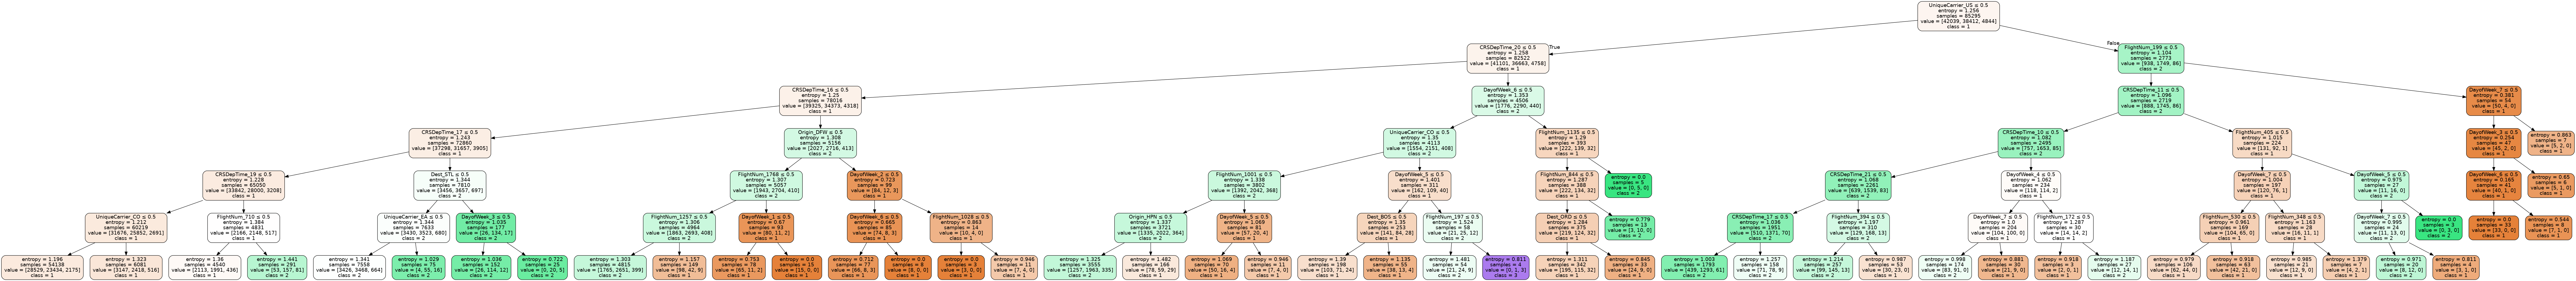

In [19]:
X = pred_enc_df.iloc[:,0:-1]
Y = pred_enc_df.iloc[:,-1]


model = DecisionTreeClassifier(criterion="entropy", max_depth=6, random_state=0)
model.fit(X, Y)
text_representation = tree.export_text(model,feature_names=X.columns.values.tolist())
print(text_representation)

dot_data = StringIO()
export_graphviz(model, out_file=dot_data,
                feature_names=X.columns,
                class_names=["1", "2", "3"],
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())